## Heuristic 4 - Preliminary implementation

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [23]:
# Import relevant packages.
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")

In [3]:
tornado_addresses = {
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3": "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144": "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730": "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334": "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc": "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936": "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf": "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291": "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307": "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d": "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b": "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f": "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1": "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4": "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498": "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b": "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003": "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701": "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af": "5000000 cDAI"
}

In [4]:
withdraw_transactions_df

,Unnamed: 0,Unnamed: 0.1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,...,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
0,0,7,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb...,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,...,1,2020-10-05 07:57:28 UTC,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be9...,NaN,NaN,NaN,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
1,1,8,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da...,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,...,1,2020-02-11 19:10:54 UTC,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac06...,NaN,NaN,NaN,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
2,2,9,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f...,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,...,1,2020-02-16 16:05:14 UTC,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290...,NaN,NaN,NaN,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
3,3,13,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad1...,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,...,1,2020-11-09 17:08:00 UTC,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaee...,NaN,NaN,NaN,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
4,4,15,0x30becee80e63a039102df3b1243e5d314534abfcf3ed...,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,...,1,2020-11-29 01:18:57 UTC,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e...,NaN,NaN,NaN,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83777,83777,181253,0x5a36df89fa1f1ef6de7254e4b5fbfd2d6c2297ef4621...,164,188,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570447,70188284576,...,1,2021-09-05 01:23:28 UTC,13162729,0xe14fb1085bc975af1ad751aa579d7de298fb5be86c3d...,1.027888e+11,2.210156e+09,2.0,70188284576,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47
83778,83778,181255,0x43a081968e109f71a2f807f4a94ffc77429b322c3c1e...,169,168,0xe7a784acb145bd8993e83d41adf43b7c7195e995,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567923,39255417592,...,1,2021-10-03 14:49:29 UTC,13346858,0xe5a4d9c829998f00873f6ac4603174d707ffb2ea79a3...,4.000000e+10,1.130179e+09,2.0,39255417592,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xe7a784acb145bd8993e83d41adf43b7c7195e995
83779,83779,181262,0xd0708b3e2135d0378a9d6fe3fdc58b3c4fbcbcbe926c...,246,10,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567971,50193886615,...,1,2021-10-17 23:36:24 UTC,13438417,0x36808310975d158e0f2b3a2f892abed25a955684f407...,7.518635e+10,1.519911e+09,2.0,50193886615,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4
83780,83780,181263,0x54b5ceca9fd3d2ff7893c32f901f3d1d5e2e4383607b...,127,180,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570459,81048817558,...,1,2021-09-04 22:53:33 UTC,13162025,0x15a807c50ecea90cd58f5f9d6a26e0c60f3e9f06dfa6...,1.349098e+11,3.899014e+09,2.0,81048817558,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47


### Function summary: compare_transactions

Given two dictionaries, withdraw_dict and deposit_dict representing the total deposits and withdraws made by an address to each TCash pool, respectively, compares if the set of keys of both are equal and when they are, checks if all values in the deposit dictionary are equal or greater than each of the corresponding values of the withdraw dicionary. If this is the case, returns $True$, if not, $False$.

In [5]:
def compare_transactions(withdraw_dict, deposit_dict):
    if set(withdraw_dict.keys()) != set(deposit_dict.keys()):
        return False
    for currency in withdraw_dict.keys():
        if not (deposit_dict[currency] >= withdraw_dict[currency]):
            return False
    return True

### Function summary: get_number_of_withdraws

Given a particular withdraw transaction and the withdraw transactions DataFrame, gets the total withdraws the address made in each pool. It is returned as a dictionary with the pools as the keys and the number of withdraws as the values.

In [6]:
def get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses):
    
    n_withdraws = {tornado_addresses[withdraw_transaction.tornado_cash_address]: 1}
    
    for withdraw_row in withdraw_transactions_df.itertuples():
        if (withdraw_row.recipient_address == withdraw_transaction.recipient_address) and (withdraw_row.block_timestamp <= withdraw_transaction.block_timestamp) and (withdraw_row.hash != withdraw_transaction.hash):
            if tornado_addresses[withdraw_row.tornado_cash_address] in n_withdraws.keys():
                n_withdraws[tornado_addresses[withdraw_row.tornado_cash_address]] += 1
            else:
                n_withdraws[tornado_addresses[withdraw_row.tornado_cash_address]] = 1
    return n_withdraws

### Function summary: get_address_deposits

Given the deposit transactions DataFrame, returns a dictionary with every address of the deposit

In [7]:
def get_address_deposits(deposit_transactions_df, tornado_addresses):
    
    addresses_and_deposits_counts = pd.DataFrame(deposit_transactions_df[["from_address", "tornado_cash_address"]].value_counts()).rename(columns={0:"count"})
    
    addresses_and_deposits_dict = {}
    for row in addresses_and_deposits_counts.itertuples():
        if row.Index[0] in addresses_and_deposits_dict.keys():
            addresses_and_deposits_dict[row.Index[0]][tornado_addresses[row.Index[1]]] = row.count
        else:
            addresses_and_deposits_dict[row.Index[0]] = {tornado_addresses[row.Index[1]]: row.count}
            
    return addresses_and_deposits_dict

In [8]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
address_deposits

{'0x16e54b35d789832440ab47ae765e6a8098280676': {'0.1 ETH': 1068,
  '100 USDT': 1},
 '0x35dd029618f4e1835008da21fd98850c776453f0': {'0.1 ETH': 628},
 '0xe906442c11b85acbc58eccb253b9a55a20b80a56': {'0.1 ETH': 562},
 '0xaf301de836c81deb8dff9dc22745e23c476155b2': {'1 ETH': 503,
  '0.1 ETH': 96,
  '10 ETH': 8},
 '0xdc4dcbc3f199a8b6ba51bdfd9db46051ab88a2f7': {'1 ETH': 395},
 '0xb9d8ee59a0e5f908d3a87b8b272593761b40f298': {'1 ETH': 296},
 '0xd88189f7dee6e5dbd6cbc6f06fd357f4bf7f330b': {'100 ETH': 282, '10 WBTC': 80},
 '0x30030383d959675ec884e7ec88f05ee0f186cc06': {'100 ETH': 282},
 '0xe0e484dfa7f3aa36733a915d6f07eb5a57a74a11': {'100 ETH': 264,
  '100000 DAI': 50},
 '0x592c67dc41f6e5a7a39a836b031beb555cbef2f5': {'1 ETH': 251},
 '0x5386bb30475c4f6aac993faac62c3093ca0ac26d': {'1 ETH': 251},
 '0x6a1cf24c645db2e37141fa12e70cb67e56b336f3': {'0.1 ETH': 204, '10 ETH': 1},
 '0x0ad942b82c46cd22f4936ca7011e3a3c57755707': {'1 ETH': 202},
 '0xda8774d99fba48cfa13344285259401d93304a60': {'1 WBTC': 200},
 '0xa

In [9]:
get_number_of_withdraws(withdraw_transactions_df.iloc[2], withdraw_transactions_df, tornado_addresses)

{'1000 USDC': 2, '100 ETH': 1, '0.1 ETH': 1}

In [10]:
d = {'1 ETH': 93,
  '100 ETH': 4,
  '1 WBTC': 3,
  '0.1 ETH': 1,
  '0.1 WBTC': 1}

In [11]:
def get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses):
    
    return list(dict(filter(lambda elem: compare_transactions(n_withdraws, elem[1]), address_deposits.items())).keys())

In [12]:
get_same_or_more_number_of_deposits(d, address_deposits, tornado_addresses)

['0x6e8df51931f8675cf7e12447e1fe25b26c8775c7']

In [13]:
def same_number_of_deposits_heuristic(withdraw_transaction, address_deposits, withdraw_transactions_df, tornado_addresses):
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)

    C = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    try:
        return 1 - 1/len(C)
    except:
        return 1

In [14]:
def apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses):
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    tx_hash_and_anonimity_score = {}
    
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total = withdraw_transactions_df.shape[0], mininterval=5):
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, address_deposits, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score

    return tx_hash_and_anonimity_score

In [15]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)

100%|███████████████████████████████████████████████████████████████████████████████████| 83782/83782 [5:44:45<00:00,  4.05it/s]


In [22]:
scores

{'0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb92887517e20b237907e3': 0.997737556561086,
 '0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d': 0.0,
 '0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f70c9a24e90f927672699': 1,
 '0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad11b91faa77bb852599b76': 0.9975,
 '0x30becee80e63a039102df3b1243e5d314534abfcf3ed0fc4eadb2dc5b1c45ab7': 0.9998073959938367,
 '0x5ef2e6d75efa800f009a84b27ae22609597edee8df8ee8699c004af233cf5855': 0.9998073959938367,
 '0x59d6d259118b41170550e5662c35b20c1b8ba795e420f6ce7a74772a9a834492': 0.9997776295307983,
 '0x805b2ae79b5267a23e6c79d3324d43dae0f64e81f77f166c09dca9ff46cfc955': 0.9997776295307983,
 '0x099005f439f7d44f5542af236dfd0ba7d93c75e9a32887950953f57cee730793': 0.9990583804143126,
 '0x95d478a0b607f7c0d27ab1b522ce47c67c8281200154097a95f8fc0307ca67c4': 0.9893617021276596,
 '0x795de0514ec2b5e9421a0730c5d837c4ac3387d7cfb19f9f81f00601d9a781ac': 0.9997814685314685,
 '0xc88addb452a33385ce282b973ccc7a72c9631d4f

In [16]:
addresses_and_deposits_counts = pd.DataFrame(deposit_transactions_df[["from_address", "tornado_cash_address"]].value_counts()).rename(columns={0:"count"})


In [17]:
addresses_and_deposits_counts

,,count
from_address,tornado_cash_address,
0x16e54b35d789832440ab47ae765e6a8098280676,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1068
0x35dd029618f4e1835008da21fd98850c776453f0,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,628
0xe906442c11b85acbc58eccb253b9a55a20b80a56,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,562
0xaf301de836c81deb8dff9dc22745e23c476155b2,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,503
0xdc4dcbc3f199a8b6ba51bdfd9db46051ab88a2f7,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,395
...,...,...
0x6b2dce929f92566ef5e8735d673937bd66911235,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1
0x6b29132ea388a308578c1d3be068d0e4fc9915a2,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1
0x6b224509ccad772634b2a2cecdcd7dcc770ec973,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,1


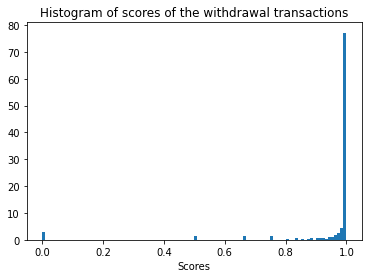

In [29]:
plt.hist(scores.values(), bins=100, density=True)
plt.title("Histogram of scores of the withdrawal transactions")
plt.xlabel("Scores")
plt.show()